In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import scipy.stats as stats
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression as LR
import sklearn.metrics as m

input_folder='/kaggle/input/titanic/'

### Load the data sets

In [2]:
train_data = pd.read_csv(input_folder+'train.csv')
test_data = pd.read_csv(input_folder+'test.csv')

### Search for missing values

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


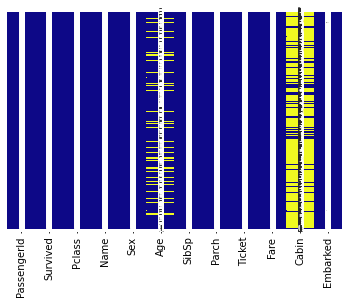

In [4]:
print(train_data.isnull().sum()*100/train_data.isnull().count())
# About 20% of age is missing, about 77% of cabin is missing, 0.22% of embarked is missing

sns.heatmap(train_data.isnull(),
            annot=True,
            yticklabels=False,
            cbar=False,
            cmap='plasma')

### Correlation plot

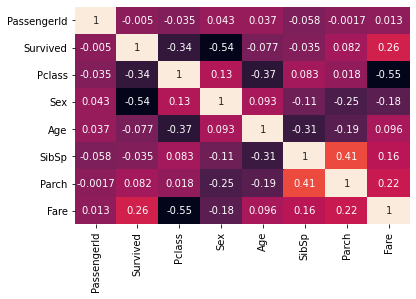

In [10]:
# We need to change sex to a numerical value, otherwise the correlation plot will not include sex
train_data['Sex'] = train_data['Sex'].astype('category')
train_data['Sex'] = train_data['Sex'].cat.codes


sns.heatmap(train_data.corr(),
           annot=True,
           cbar=False)

> Survival is highly correlated with Pclass, Fare, and Sex.
> Pclass and Fare, however, are also highly correlated since one represents the price of the class and the other is the class (1st, 2nd, 3rd).
> For this reason, I will use either the Fare or the Pclass as a predictor, and never both.

> 

### Select columns to be analyzed

In [ ]:
train_filtered = train_data.filter(['Survived','Pclass','Sex','Age','Fare'])
train_filtered.dropna(how='any',axis='rows', inplace=True)

test_filtered = test_data.filter(['Survived','Pclass','Sex','Age','Fare','PassengerId'])
test_filtered.dropna(how='any',axis='rows', inplace=True)

### Switch categorical variables to integers

In [ ]:
train_filtered['Sex'] = train_filtered['Sex'].astype('category')
train_filtered['Sex'] = train_filtered['Sex'].cat.codes

test_filtered['Sex'] = test_filtered['Sex'].astype('category')
test_filtered['Sex'] = test_filtered['Sex'].cat.codes

### Visual inspection of the data

In [ ]:
# Survival by pclass
g = sns.jointplot(train_filtered.groupby(['Pclass']).sum().index,
                  train_filtered.groupby(['Pclass']).sum()['Survived']
    )

# Survival by sex
g = sns.jointplot(train_filtered.groupby(['Sex']).sum().index,
                  train_filtered.groupby(['Sex']).sum()['Survived']
    )

# Survival by age
g = sns.jointplot(train_filtered.groupby(['Age']).sum().index,
                  train_filtered.groupby(['Age']).sum()['Survived']
    )

# Survival by fare
g = sns.jointplot(train_filtered.groupby(['Fare']).sum().index,
                  train_filtered.groupby(['Fare']).sum()['Survived']
    )

### Test if a logistic regression model works well using only the training data

In [ ]:
# Split data into test and train sets based on the train data set
X_train, X_test, y_train, y_test = train_test_split(
    train_filtered.drop('Survived', axis=1), train_filtered['Survived'], test_size=0.33)

# Train model
model = LR().fit(y=y_train,X=X_train)

# Predict results
results = model.predict(X_test)

# Add results to a data frame
res = pd.DataFrame(data=y_test.tolist(),columns=['Survived actual'])
res['Survived predicted'] = results

# Confusion matrix
confmatrix=m.confusion_matrix(res['Survived actual'],res['Survived predicted'])
sns.heatmap(confmatrix,annot=True,fmt='d',cbar=0).set_title('Confusion Matrix')
#   True negatives (tn)     True positives (tp)
#   False negatives (fn)    False positives (fp)

print('Accuracy: '+str(m.accuracy_score(res['Survived actual'],res['Survived predicted']))) # percent of accurate classification
print('Precision: '+str(m.precision_score(res['Survived actual'],res['Survived predicted']))) # tp / (tp + fp), 0 is worst, 1 is best
print('Recall: '+str(m.recall_score(res['Survived actual'],res['Survived predicted']))) # tp / (tp + fn), 0 is worst, 1 is best

> In this case, I will consider that the features selected are good predictors of survivability. 
> Therefore, I will apply the same model to the whole training data set and get the results for the test data set

### Predict survival based on the test data set

In [ ]:
# Train model
model = LR().fit(y=train_filtered['Survived'],X=train_filtered.drop('Survived', axis=1))

# Predict survival for the test set
results = model.predict(test_filtered.drop('PassengerId', axis=1))

res = pd.DataFrame(data=results.tolist(), columns = ['Survived'])
res['PassengerId'] = test_filtered['PassengerId'].astype(int)

print(res)

### Save csv to file

In [ ]:
res.to_csv('results.csv', index=False)